<a id="top"></a>

<center>
    <h1>Coffee for the Newcomers: A Case Study of Gentrification in Brooklyn</h1>
    <h3>Rushil Mallarapu, 2020</h3>
</center>

Welcome to the project notebook for *Coffee for the Newcomers: A Case Study of Gentrification in Brooklyn*! We are glad you are taking the time to check this out. If you want to see the project report, [click here](https://github.com/sudo-rushil/Coursera_Capstone/blob/master/report.pdf). In summary, we study the relation between neighborhood median household income and neighborhood character in Brooklyn to quantify the changes gentrification brings to neighborhoods outside traditional standard-of-living metrics. We use clustering to find groupings of neighborhoods with similar character, in terms of the type of venues common in the region, and search for regression models between neighborhood venue frequency and median household income. This case study demonstrates the effect gentrification has on the urban community, and offers valuable insight for government planners and business owners looking to develop cities.

### Table of Contents

- [Part 1: Load geographical data](#geo)
- [Part 2: Load income data](#income)
- [Part 3: Pull Foursquare venue data](#foursquare)
- [Part 4: Process and cluster venue data](#cluster)
- [Part 5: Correlate clusters with income and analyze](#analyze)
- [Part 6: Build regression models](#regression)

Let's begin by importing all the libraries we'll need.

In [128]:
# For effcient data manipulation and processing, essential for any data analysis stack.
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# For connecting with the Foursquare API
import requests, json

# For plotting data and generating maps
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline

# For retriving geographic coordinates for different regions
import geopy.geocoders
from geopy.geocoders import ArcGIS
geopy.geocoders.options.default_timeout = None

# For clustering and regression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import median_absolute_error
from sklearn.preprocessing import StandardScaler

<a id="geo"></a>

# Part 1: Load geographic data

[Home](#top)

Our first job is to load in the geographic data. The `nyu.json` file has all the neighborhood locations. Meanwhile, the `brooklyn.json` file has all the Brooklyn location boundaries. We process this into one dataframe - `brooklyn` has the location of all neighborhoods - and one GeoJSON file `brooklyn_data` that has all the boundaries.

In [2]:
# Load the nyu.json file into a string
with open('data/nyu.json') as json_data:
    newyork_data = json.load(json_data)

# Load the brooklyn.json file
with open('data/brooklyn.json') as json_data:
    brooklyn_data = json.load(json_data)

Here, we define a function to parse the raw neighborhood data into a dataframe.

In [131]:
def assemble_dataset(nyc_data):
    # Create list of all the raw neighborhood data
    neighborhoods_data = nyc_data['features']
    
    # Initialize empty dataframe
    neighborhoods = pd.DataFrame(columns=['Neighborhood', 'Latitude', 'Longitude'])

    for data in neighborhoods_data:
        # Ensure we only have the neighborhoods that are in Brooklyn
        if data['properties']['borough'] != 'Brooklyn': continue
    
        # Extract data from the JSON file
        name = data['properties']['name']
        lon, lat = data['geometry']['coordinates']
        
        # Append data back into dataframe
        neighborhoods = neighborhoods.append({'Neighborhood': name,
                                              'Latitude': lat,
                                              'Longitude': lon}, ignore_index=True)
    
    return neighborhoods

Now, we can use this function to assemble the `brooklyn` dataframe of the location of Brooklyn neighborhoods. Let's also take a look at the shape of the dataframe.

In [134]:
brooklyn = assemble_dataset(newyork_data)

print(f"Brooklyn has {brooklyn.shape[0]} neighborhoods")
brooklyn.head()

Brooklyn has 70 neighborhoods


,Neighborhood,Latitude,Longitude
0,Bay Ridge,40.625801,-74.030621
1,Bensonhurst,40.611009,-73.995180
2,Sunset Park,40.645103,-74.010316
3,Greenpoint,40.730201,-73.954241
4,Gravesend,40.595260,-73.973471


Let us try to map out the neighborhoods. For that, we'll need to know Brooklyn's coordinates, which we can look up using the ArcGIs geolocator.

In [127]:
# Instantiate the geolocator and find the location of Brooklyn
geolocator = ArcGIS()
_, (latitude, longitude) = geolocator.geocode('Brooklyn, NY')

print(f"Brooklyn's coordinates are {latitude:.4f}, {longitude:.4f}.")

Brooklyn's coordinates are 40.6925, -73.9904.


Now, we can map the geographic data of interest. The blue polygons are regions in Brooklyn, while the blue dots represent specific neighborhoods. Note that income data is available for the regions, but venue data will be acquired for the neighborhoods themselves.

In [141]:
# Instantiate the map
map_brooklyn = folium.Map(
    location=[latitude-4.4e-2, longitude+4e-2], 
    zoom_start=11
)

# Add the labels for each neighborhood in Brooklyn
for lat, lng, label in zip(brooklyn['Latitude'], brooklyn['Longitude'], brooklyn['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False
    ).add_to(map_brooklyn)  

# Add the district boundary overlay
folium.GeoJson(
    brooklyn_data,
    name='geojson'
).add_to(map_brooklyn)
    
# display the map
map_brooklyn

<a id="income"></a>
       
# Part 2: Load income data

[Home](#top)

Now that we've defined the location data, we can load in the neighborhood income data. This is stored in the `income.csv` file, which was created by manually matching zip code-level median household income data from the US Census Bureau's 2018 American Community Survey 5-year estimate, and cleaning the resulting dataset. Then, we can plot out these incomes using a choropleth map.

In [135]:
# Load the dataset
brooklyn_income = pd.read_csv('data/income.csv')

# Drop the borough column, as it will all say Brooklyn, and rename the columns for better consistency
brooklyn_income.drop(["Borough"], 1, inplace=True)
brooklyn_income.columns = ['Neighborhoods', 'Income']

brooklyn_income.head()

,Neighborhoods,Income
0,Bath Beach,54041
1,Bay Ridge,72314
2,Bedford-Stuyvesant,47706
3,Bensonhurst,49785
4,Bergen Beach,81399


We should plot this income data in a choropleth map, so as to visualize the geographic distribution of wealth in Brooklyn. On the image, darker green corresponds to higher median household income. Let us also show where the neighborhood locations are.

In [142]:
# Instantiate the map
map_income = folium.Map(
    location=[latitude-4.4e-2, longitude+4e-2],
    zoom_start=12
)

# Add the choropleth map, matching neighborhoods in the GeoJSON data and income dataframe
folium.Choropleth(
    geo_data=brooklyn_data,
    name='choropleth',
    data=brooklyn_income,
    columns=['Neighborhoods', 'Income'],
    key_on='feature.properties.name',
    fill_color='Greens',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median Household Income'
).add_to(map_income)

# Add in the neighborhood labels
for lat, lng, label in zip(brooklyn['Latitude'], brooklyn['Longitude'], brooklyn['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#ffffff',
        fill_opacity=0,
        parse_html=False
    ).add_to(map_income)  

# Collimate map layers
folium.LayerControl().add_to(map_income)

# Display map
map_income

We see that the northwestern corner of Brooklyn, as well as the side facing out into the bay, are the wealthiest. Conversely, the poorest regions are concentrated to the east of the Borough. Luckily, there is a variety of neighborhoods, often multiple in each district. As such, it is likely that some isolated neighborhoods will have a higher average income than the larger district they are found in. This observation will be critically when analyzing clusters later.

<a id="foursquare"></a>

# Part 3: Pull Foursquare venue data

[Home](#top)

For the interesting part: We will use the Foursquare API to pull data ()

In [10]:
CLIENT_ID = '34D1YPS0PXJOOPO3REYJDXPPTCOUYHCO53L55FDUEACHMDIX'
CLIENT_SECRET = 'Z2L254FJLXQAMSGZQ3NKDEYAMFUZDZGOZFDHQRUAN3Z1VK30'
VERSION = '20200321'

RADIUS, LIMIT = 500, 200

In [11]:
def get_nearby_venues(names, latitudes, longitudes, radius=RADIUS, limit=LIMIT):
    
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, end=' ')
        
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id\
                ={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}\
                &radius={radius}&limit={limit}'
        
        try:
            results = requests.get(url).json()['response']['groups'][0]['items']
        except:
            continue
        
        venues_list.append([(
            name,
            lat,
            lng,
            venue['venue']['name'],
            venue['venue']['location']['lat'],
            venue['venue']['location']['lng'],
            venue['venue']['categories'][0]['name']) for venue in results
        ])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Neighborhood',
        'Neighborhood Latitude',
        'Neighborhood Longitude',
        'Venue',
        'Venue Latitude',
        'Venue Longitude',
        'Venue Category'
    ]
    
    return nearby_venues

In [68]:
# brooklyn_venues = get_nearby_venues(brooklyn['Neighborhood'], 
#                                     brooklyn['Latitude'], 
#                                     brooklyn['Longitude'])

brooklyn_venues = pd.read_csv('data/venues.csv')

In [67]:
brooklyn_venues.to_csv('data/venues.csv')

In [69]:
brooklyn_venues.groupby('Neighborhood').count()['Venue'].to_frame()

,Venue
Neighborhood,
Bath Beach,44
Bay Ridge,86
Bedford Stuyvesant,29
Bensonhurst,30
Boerum Hill,92
Borough Park,20
Brighton Beach,45
Broadway Junction,21
Brooklyn Heights,100


Drop all columns with fewer than 10 venues

In [14]:
drop_hoods = brooklyn_venues.groupby('Neighborhood').count().\
                loc[brooklyn_venues.groupby('Neighborhood').count()['Venue'] < 10].index.to_list()
drop_hoods

['Bergen Beach',
 'Canarsie',
 'Dyker Heights',
 'Mill Island',
 'Paerdegat Basin',
 'Sea Gate']

In [ ]:
print(brooklyn.shape)
print(brooklyn_venues.shape)

In [15]:
drop_rows = brooklyn_venues[brooklyn_venues['Neighborhood'].isin(drop_hoods)].index
brooklyn_venues.drop(drop_rows, inplace=True)

drop_rows = brooklyn[brooklyn['Neighborhood'].isin(drop_hoods)].index
brooklyn.drop(drop_rows, inplace=True)

brooklyn_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
4,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot


In [17]:
print(brooklyn.shape)
print(brooklyn_venues.shape)

(64, 3)
(2765, 7)


<a id="cluster"></a>

# Part 4: Process and cluster venue data

[Home](#top)

In [18]:
def get_most_common(venues):
    '''
    Turn a venues dataset into a dataset showing the top 10 venues in each neighborhood.
    '''
    
    onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
    onehot.insert(0, 'Neighborhoods', venues['Neighborhood'].to_list(), True)
    grouped = onehot.groupby('Neighborhoods').mean().reset_index()
    
    neighborhoods = pd.DataFrame(columns=[
        'Neighborhood',
        'Top 1st',
        'Top 2nd',
        'Top 3rd',
        'Top 4th',
        'Top 5th',
        'Top 6th',
        'Top 7th',
        'Top 8th',
        'Top 9th',
        'Top 10th'
    ])
    
    neighborhoods['Neighborhood'] = grouped['Neighborhoods']
    
    for idx in range(grouped.shape[0]):
        neighborhoods.iloc[idx, 1:] = grouped.iloc[idx, 1:].sort_values(ascending=False).index.values[:10]
    
    return grouped, neighborhoods


In [19]:
brooklyn_grouped, brooklyn_common = get_most_common(brooklyn_venues)

print(brooklyn_grouped.shape)
print(brooklyn_common.shape)

brooklyn_common.head()

(64, 289)
(64, 11)


,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th,Top 6th,Top 7th,Top 8th,Top 9th,Top 10th
0,Bath Beach,Pharmacy,Chinese Restaurant,Sushi Restaurant,Gas Station,Pizza Place,Bubble Tea Shop,Italian Restaurant,Fast Food Restaurant,Sandwich Place,Surf Spot
1,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Greek Restaurant,American Restaurant,Bar,Ice Cream Shop,Bagel Shop,Sandwich Place,Chinese Restaurant
2,Bedford Stuyvesant,Bar,Café,Pizza Place,Deli / Bodega,Coffee Shop,Bus Stop,Bus Station,Boutique,BBQ Joint,Gift Shop
3,Bensonhurst,Pizza Place,Chinese Restaurant,Italian Restaurant,Donut Shop,Sushi Restaurant,Grocery Store,Ice Cream Shop,Cosmetics Shop,Bagel Shop,American Restaurant
4,Boerum Hill,Dance Studio,Coffee Shop,Bar,French Restaurant,Sandwich Place,Arts & Crafts Store,Bakery,Furniture / Home Store,Yoga Studio,Boutique


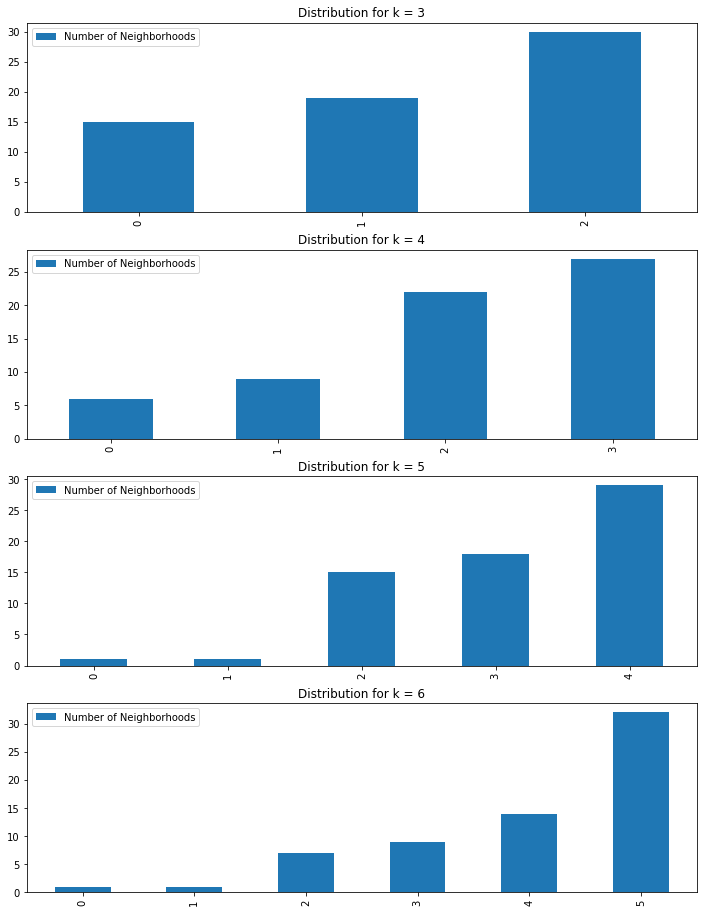

In [91]:
brooklyn_clusters = brooklyn_grouped.drop('Neighborhoods', 1)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))

for k in range(3, 7):
    kmeans_test = KMeans(n_clusters=k, random_state=0).fit(brooklyn_clusters)
    dft = pd.DataFrame(np.sort(np.unique(kmeans_test.labels_, return_counts=True)[1]), columns=['Number of Neighborhoods']).\
            plot(kind='bar', ax=axes[k - 3], title=f'Distribution for k = {k}')

plt.savefig('images/cluster_distribution.pdf', transparent=True)
plt.show()

In [22]:
kmeans = KMeans(4, random_state=0).fit(brooklyn_clusters)

brooklyn_common.insert(0, 'Cluster Labels', kmeans.labels_.astype(int))
brooklyn_merged = brooklyn
brooklyn_merged = brooklyn_merged.join(brooklyn_common.set_index('Neighborhood'), on='Neighborhood')

<a id="analyze"></a>

# Part 5: Correlate clusters with income and analyze

[Home](#top)

In [97]:
n_clusters = 4
brooklyn_income.columns = ['Neighborhoods', 'Income']
map_clusters = folium.Map(
    location=[latitude-4.4e-2, longitude+4e-2],
    zoom_start=12  # Limited levels of zoom for free Mapbox tiles.
)

folium.Choropleth(
    geo_data=brooklyn_data,
    name='choropleth',
    data=brooklyn_income,
    columns=['Neighborhoods', 'Income'],
    key_on='feature.properties.name',
    fill_color='Greens',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median Household Income'
).add_to(map_clusters)

rainbow = ['#902000', '#521038', '#047495', '#77c2d9']

for lat, lng, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)

folium.LayerControl().add_to(map_clusters)

map_clusters

In [93]:
rainbow

['#8000ff', '#2adddd', '#d4dd80', '#ff0000']

## Cluster 1

In [120]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[0] + list(range(4, brooklyn_merged.shape[1]))]]

,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th,Top 6th,Top 7th,Top 8th,Top 9th,Top 10th
3,Greenpoint,Bar,Coffee Shop,Pizza Place,Cocktail Bar,Mexican Restaurant,French Restaurant,Café,Boutique,Yoga Studio,Sushi Restaurant
12,Windsor Terrace,Diner,Deli / Bodega,Grocery Store,Plaza,Park,Café,Italian Restaurant,Sushi Restaurant,Beer Store,Bookstore
13,Prospect Heights,Bar,Bakery,Thai Restaurant,Wine Shop,Café,Cocktail Bar,Gourmet Shop,Mexican Restaurant,Yoga Studio,American Restaurant
15,Williamsburg,Bar,Coffee Shop,Pizza Place,Bagel Shop,Yoga Studio,Food Truck,Taco Place,Latin American Restaurant,Steakhouse,Liquor Store
16,Bushwick,Bar,Coffee Shop,Mexican Restaurant,Pizza Place,Deli / Bodega,Discount Store,Bakery,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Korean Restaurant
17,Bedford Stuyvesant,Bar,Café,Pizza Place,Deli / Bodega,Coffee Shop,Bus Stop,Bus Station,Boutique,BBQ Joint,Gift Shop
18,Brooklyn Heights,Yoga Studio,Park,Deli / Bodega,Cosmetics Shop,Pizza Place,Italian Restaurant,Gym,Bakery,Coffee Shop,Bar
19,Cobble Hill,Playground,Bar,Coffee Shop,Pizza Place,Yoga Studio,Cocktail Bar,Deli / Bodega,Italian Restaurant,Ice Cream Shop,Wine Shop
20,Carroll Gardens,Italian Restaurant,Coffee Shop,Pizza Place,Cocktail Bar,Bakery,Gym / Fitness Center,Wine Shop,Spa,Bar,Thai Restaurant
21,Red Hook,Seafood Restaurant,Park,American Restaurant,Art Gallery,Bar,Ice Cream Shop,Flower Shop,Wine Shop,Café,Pizza Place


## Cluster 2

In [119]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[0] + list(range(4, brooklyn_merged.shape[1]))]]

,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th,Top 6th,Top 7th,Top 8th,Top 9th,Top 10th
0,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Greek Restaurant,American Restaurant,Bar,Ice Cream Shop,Bagel Shop,Sandwich Place,Chinese Restaurant
1,Bensonhurst,Pizza Place,Chinese Restaurant,Italian Restaurant,Donut Shop,Sushi Restaurant,Grocery Store,Ice Cream Shop,Cosmetics Shop,Bagel Shop,American Restaurant
4,Gravesend,Italian Restaurant,Pizza Place,Bakery,Lounge,Martial Arts Dojo,Bus Station,Bar,Liquor Store,Furniture / Home Store,Men's Store
5,Brighton Beach,Beach,Russian Restaurant,Restaurant,Eastern European Restaurant,Gourmet Shop,Neighborhood,Sushi Restaurant,Mobile Phone Shop,Bank,Pharmacy
6,Sheepshead Bay,Dessert Shop,Turkish Restaurant,Sandwich Place,Boat or Ferry,Café,Russian Restaurant,Restaurant,Playground,Pizza Place,Yoga Studio
7,Manhattan Terrace,Ice Cream Shop,Pizza Place,Donut Shop,Coffee Shop,Mobile Phone Shop,Steakhouse,Organic Grocery,Grocery Store,Restaurant,Eastern European Restaurant
9,Crown Heights,Pizza Place,Café,Museum,Bagel Shop,Salon / Barbershop,Sushi Restaurant,Burger Joint,Electronics Store,Candy Store,Supermarket
11,Kensington,Thai Restaurant,Grocery Store,Ice Cream Shop,Sandwich Place,Pizza Place,Lingerie Store,Liquor Store,Spa,Deli / Bodega,Mexican Restaurant
14,Brownsville,Restaurant,Moving Target,Chinese Restaurant,Park,Pizza Place,Performing Arts Venue,Playground,Fried Chicken Joint,Farmers Market,Spanish Restaurant
31,Manhattan Beach,Bus Stop,Café,Ice Cream Shop,Harbor / Marina,Food,Beach,Sandwich Place,Playground,Pizza Place,Discount Store


## Cluster 3

In [118]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[0] + list(range(4, brooklyn_merged.shape[1]))]]

,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th,Top 6th,Top 7th,Top 8th,Top 9th,Top 10th
8,Flatbush,Mexican Restaurant,Caribbean Restaurant,Coffee Shop,Chinese Restaurant,Lounge,Bank,Bagel Shop,Juice Bar,Donut Shop,Sandwich Place
10,East Flatbush,Food,Pharmacy,Caribbean Restaurant,Food & Drink Shop,Fast Food Restaurant,Park,Hardware Store,Supermarket,Moving Target,Print Shop
27,Starrett City,Pharmacy,Supermarket,Pizza Place,Caribbean Restaurant,American Restaurant,Convenience Store,Shopping Mall,Donut Shop,Yoga Studio,Field
29,Flatlands,Pharmacy,Fried Chicken Joint,Fast Food Restaurant,Caribbean Restaurant,Deli / Bodega,Park,Nightclub,Lounge,Electronics Store,Chinese Restaurant
32,Coney Island,Caribbean Restaurant,Baseball Stadium,Pizza Place,Clothing Store,Skating Rink,Music Venue,Farmers Market,Beach,Monument / Landmark,Theme Park Ride / Attraction
47,Prospect Park South,Caribbean Restaurant,Grocery Store,Pizza Place,Fast Food Restaurant,Mobile Phone Shop,Latin American Restaurant,Deli / Bodega,Donut Shop,Mexican Restaurant,Mattress Store
56,Rugby,Caribbean Restaurant,Bank,Grocery Store,Pizza Place,Diner,Seafood Restaurant,Fast Food Restaurant,Fried Chicken Joint,Supermarket,Pharmacy
57,Remsen Village,Caribbean Restaurant,Fast Food Restaurant,Breakfast Spot,Donut Shop,Fried Chicken Joint,Fish Market,Supermarket,Sandwich Place,Auto Dealership,Salad Place
69,Erasmus,Caribbean Restaurant,Grocery Store,Chinese Restaurant,Yoga Studio,Pharmacy,Convenience Store,Donut Shop,Bus Line,Music Venue,Playground


## Cluster 4

In [121]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 3, brooklyn_merged.columns[[0] + list(range(4, brooklyn_merged.shape[1]))]]

,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th,Top 6th,Top 7th,Top 8th,Top 9th,Top 10th
2,Sunset Park,Bank,Bakery,Pizza Place,Mexican Restaurant,Latin American Restaurant,Fried Chicken Joint,Mobile Phone Shop,Pharmacy,Gym,Grocery Store
25,Cypress Hills,Latin American Restaurant,Fried Chicken Joint,Ice Cream Shop,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Gas Station,Supermarket,Metro Station,Food
26,East New York,Deli / Bodega,Event Service,Fried Chicken Joint,Gym,Fast Food Restaurant,Bus Station,Caribbean Restaurant,Metro Station,Music Venue,Pizza Place
34,Borough Park,Bank,Pizza Place,Pharmacy,Coffee Shop,Café,Deli / Bodega,American Restaurant,Hotel,Chinese Restaurant,Grocery Store
46,Midwood,Pizza Place,Ice Cream Shop,Candy Store,Bakery,Bagel Shop,Convenience Store,Pharmacy,Video Game Store,Field,Falafel Restaurant
58,New Lots,Pizza Place,Grocery Store,Fried Chicken Joint,Plaza,Breakfast Spot,Chinese Restaurant,Bank,Metro Station,Asian Restaurant,Park


<a id="regression"></a>

# Part 6: Build regression models

[Home](#top)

In [27]:
# Join place frequency and income datasets on valid keys for regression purposes

# brooklyn_income.columns = ['Neighborhoods', 'Income']
brooklyn_regression = brooklyn_income.join(brooklyn_grouped.set_index('Neighborhoods'), on='Neighborhoods', how='inner')
brooklyn_regression.head()

,Neighborhoods,Income,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Sto

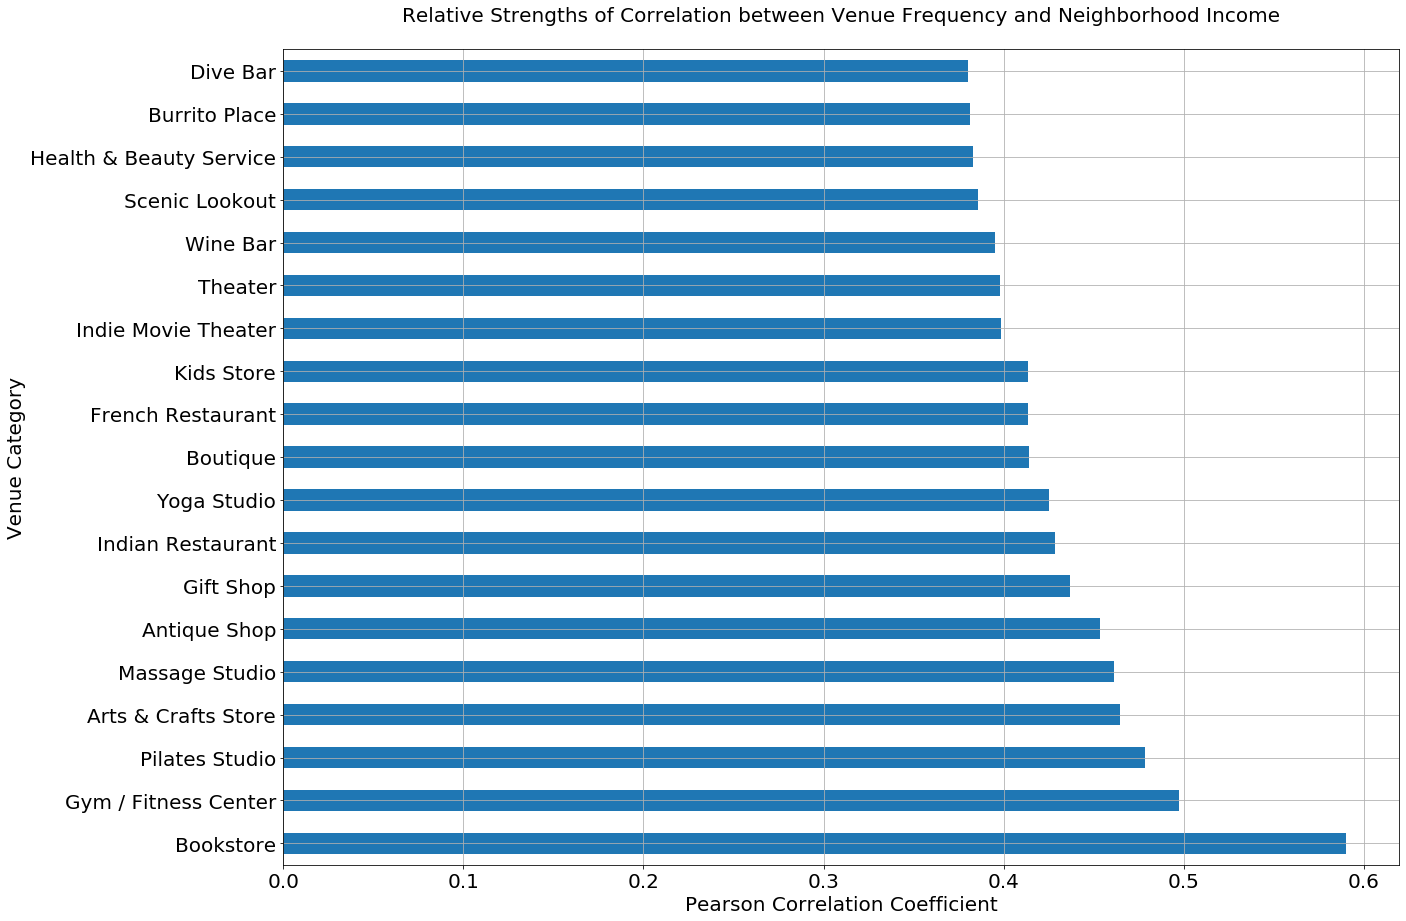

In [98]:
brooklyn_regression.corr()['Income'].sort_values(ascending=False)[1:20].plot(kind='barh', figsize=(20, 15), grid=True, fontsize=20)
plt.xlabel('Pearson Correlation Coefficient', fontsize=20)
plt.ylabel('Venue Category', fontsize=20)
plt.title('Relative Strengths of Correlation between Venue Frequency and Neighborhood Income\n', fontsize=20)
plt.savefig('images/top_correlations.pdf', transparent=True)
plt.show()

In [29]:
top_values = brooklyn_regression.corr()['Income'].sort_values(ascending=False)[1:20].index.to_list()
top_values

['Bookstore',
 'Gym / Fitness Center',
 'Pilates Studio',
 'Arts & Crafts Store',
 'Massage Studio',
 'Antique Shop',
 'Gift Shop',
 'Indian Restaurant',
 'Yoga Studio',
 'Boutique',
 'French Restaurant',
 'Kids Store',
 'Indie Movie Theater',
 'Theater',
 'Wine Bar',
 'Scenic Lookout',
 'Health & Beauty Service',
 'Burrito Place',
 'Dive Bar']

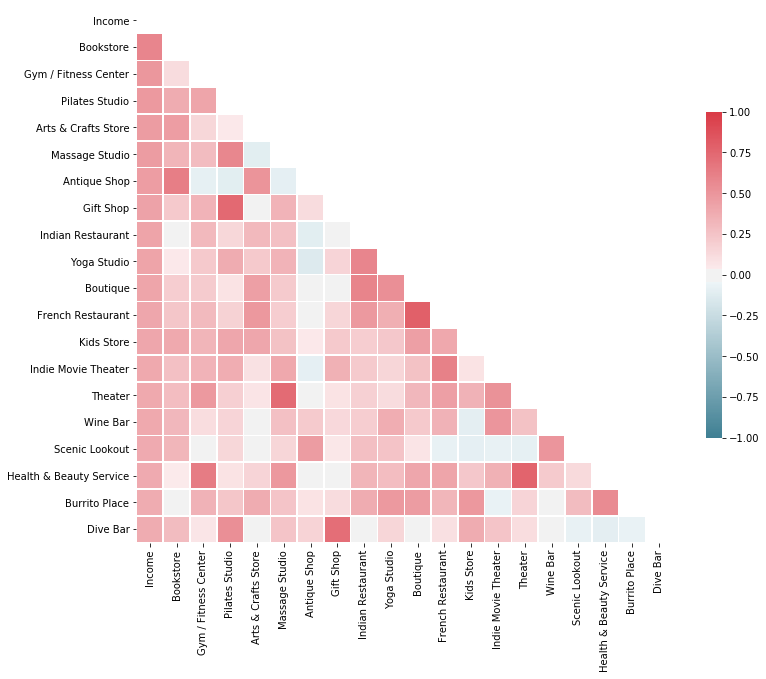

In [112]:
corr = brooklyn_regression[['Income'] + top_values].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(12, 12))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., vmin=-1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig('images/top_heatmap.pdf', transparent=True)

In [46]:
X, y = brooklyn_regression[top_values].values, brooklyn_regression['Income'].values
y = StandardScaler().fit(y.reshape(-1, 1)).transform(y.reshape(-1, 1)).reshape(-1)
X = StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [48]:
ridge, linear = RidgeCV().fit(X_train, y_train), LinearRegression().fit(X_train, y_train)
print(ridge.score(X_train, y_train))
print(linear.score(X_train, y_train))

0.796042981051494
0.8409029243754271


In [49]:
y_hat_ridge = ridge.predict(X_test)
y_hat_linear = linear.predict(X_test)

print(f'Ridge Regression {median_absolute_error(y_test, y_hat_ridge):.4f}')
print(f'Linear Regression {median_absolute_error(y_test, y_hat_linear):.4f}')

Ridge Regression 0.5226
Linear Regression 0.6224


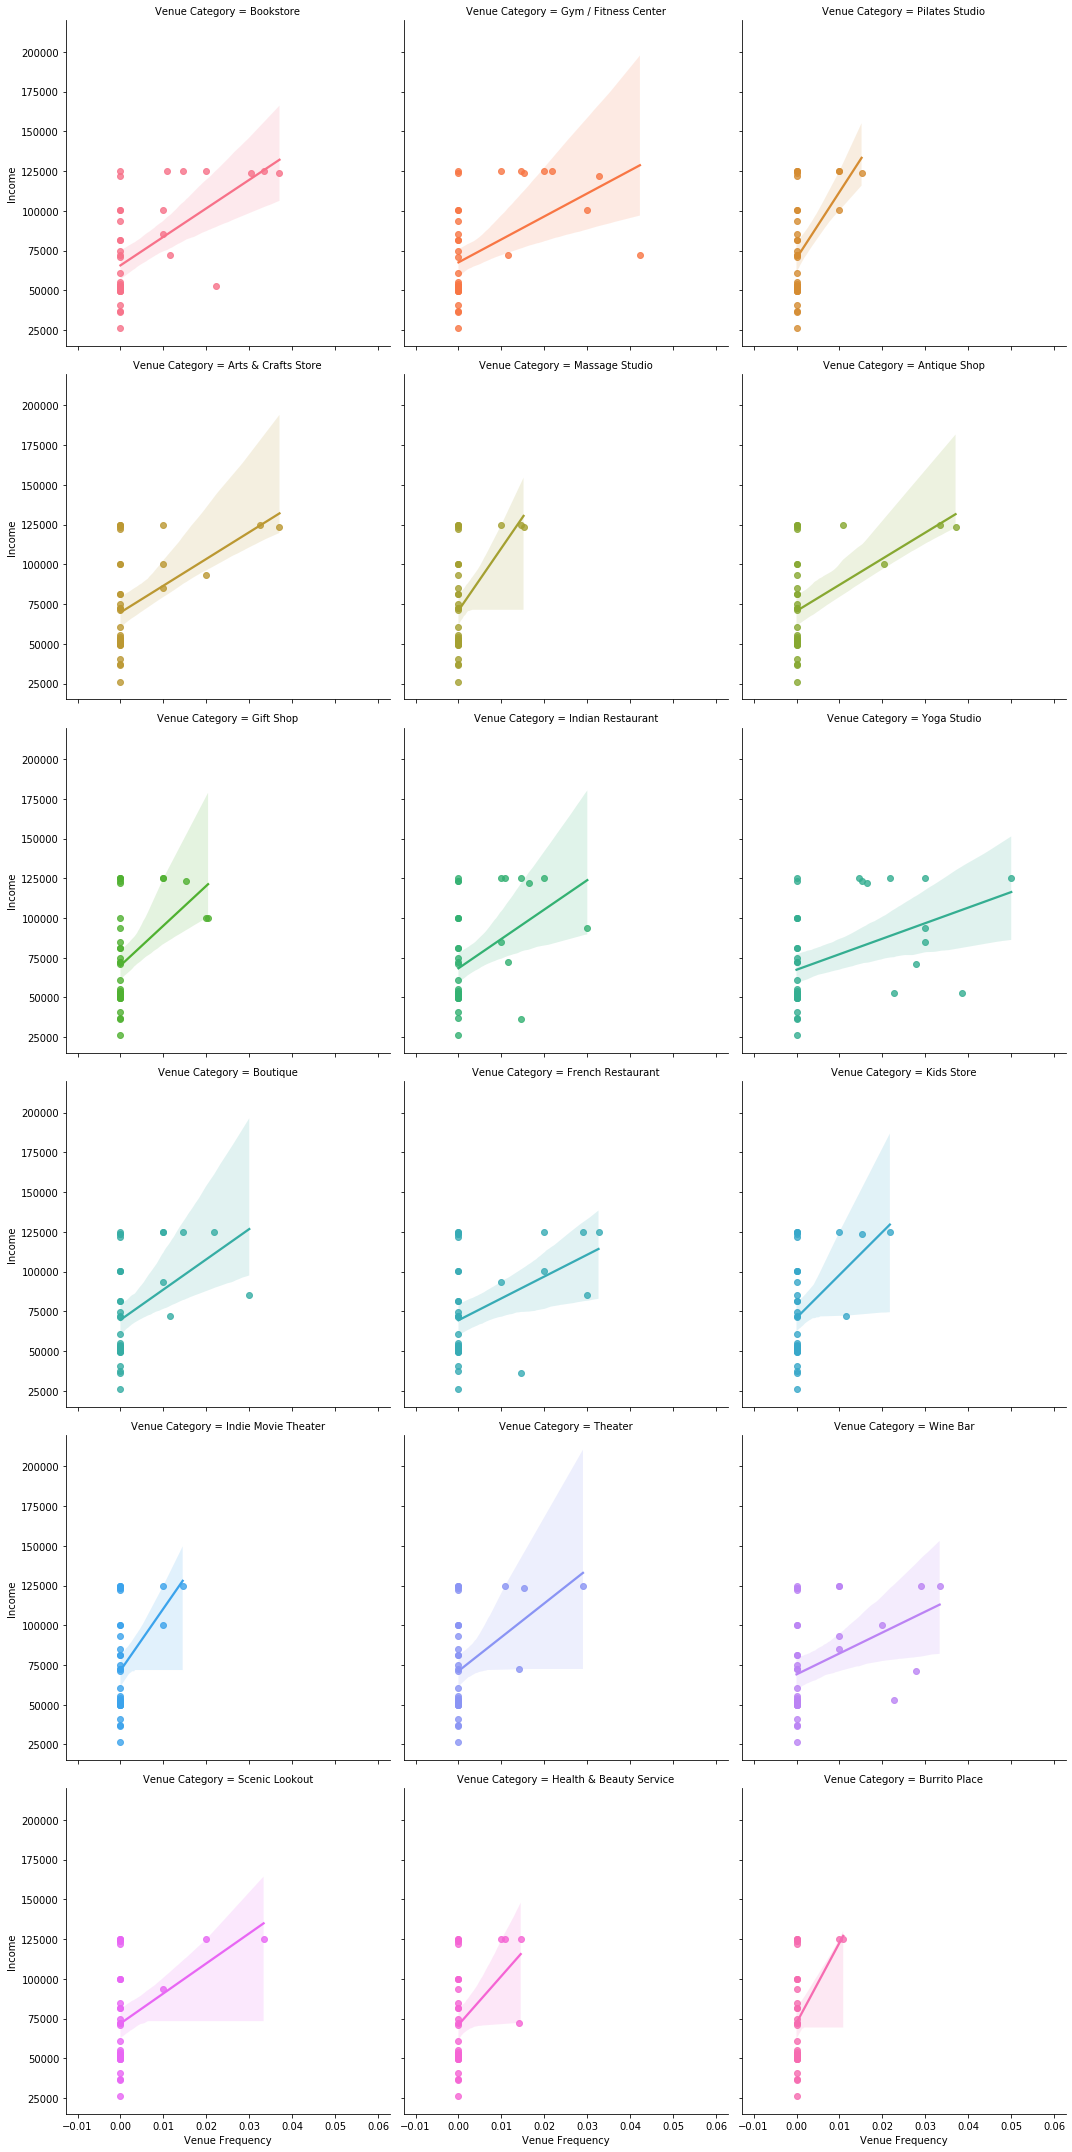

In [123]:
dft = brooklyn_regression[['Income'] + top_values[:-1]].melt('Income')
dft.columns = ['Income', 'Venue Category', 'Venue Frequency']

sns.lmplot(data=dft, x='Venue Frequency', y='Income', hue='Venue Category', col='Venue Category', col_wrap=3)
plt.savefig('images/top_regressions.pdf', transparent=True)